# Buckinghorse forced with 4km WRF

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pysumma as ps
import pysumma.plotting as psp
import xarray as xr
import pandas as pd
import numpy as np
import summa_check as sc
import io
import sys
import datetime
from sklearn.metrics import mean_squared_error
import math

In [2]:
uw_wrf = xr.open_dataset('./forcings/buck_era5_2016.nc')
ncar_wrf = xr.open_dataset('./forcings/buck_2019_v5.nc')
buck = uw_wrf

In [ ]:
# run summa check on forcing file to ensure forcing file is set up correctly
sc.final('buckinghorse', 'WA')

In [ ]:
# can plot forcing variables if interested to check veracity of data
'''for var in buck.data_vars:
    if len(buck[var].shape) == 2:
        plt.figure(figsize=(10,6))
        # print(var)
        # print(buck.time.shape)
        # print(buck[var].shape)
        print(f'max: {buck[var].max().values}')
        print(f'min: {buck[var].min().values}')
        print(f'isnan: {(np.isnan(buck[var].values)).sum()}')
        print(f'is not finite: {(~np.isfinite(buck[var].values)).sum()}')
        
        
        plt.plot(buck.time, buck[var])
        plt.title(var)
        # plt.xlim(np.datetime64('2015-11-07'),np.datetime64('2015-11-09'))
        plt.show()
        input()'''

In [4]:
# define executable and file manager path
executable = 'summa.exe'
filemanager = '/home/jovyan/data/buckinghorse/settings/file_manager_buck.txt'

In [5]:
# define executable and file manager path
executable = 'summa.exe'
filemanager = '/home/jovyan/data/buckinghorse/settings/file_manager_buck.txt'

# set up simulation
s = ps.Simulation(executable, filemanager)

# define start and end of model run
start = '2015-10-01 00:00'
end = '2016-07-01 00:00'
s.manager['simStartTime'] = start
s.manager['simEndTime'] = end

# Add in some additional variables so we can demonstrate plotting capabilities
output_settings = {'period': 1, 'instant': 1, 'sum': 0, 
              'mean': 0, 'variance': 0, 'min': 0, 'max': 0}
layer_vars = ['mLayerTemp', 'mLayerDepth', 'mLayerHeight',
              'mLayerLiqFluxSoil', 'mLayerVolFracIce', 'mLayerVolFracLiq', 
              'mLayerVolFracWat','mLayerMatricHead', 'iLayerHeight', 'scalarSnowDepth', 'nSnow']

# Create the new variables
for var in layer_vars:
    s.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s.output_control.options])
for var in all_vars:
    s.output_control[var] = output_settings

In [6]:
# set the rain/snow partitioning to 1C
s.global_hru_params['tempCritRain'] = 274.15

In [9]:
# initialize model and define output file suffix
s.run('local', run_suffix='_era_eLW_2016')
print(s.stdout)

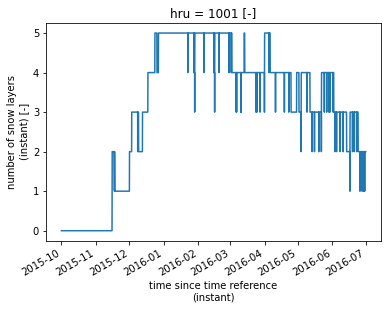

In [11]:
# plot the number of layers throughout the simulation
s.output['nSnow'].isel(hru=0).plot()

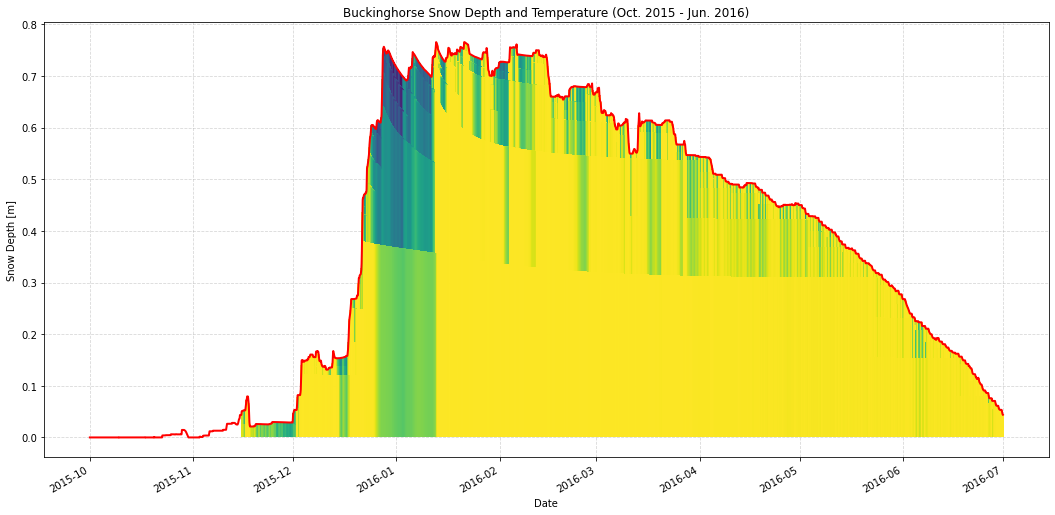

In [12]:
# define variables to be plotted from output
depth = s.output.isel(hru=0)['iLayerHeight']
temp = s.output.isel(hru=0)['mLayerTemp']
frac_wat = s.output.isel(hru=0)['mLayerVolFracWat']

# plot snow depth and layer temperature
plot = psp.layers(temp, depth, colormap='viridis', plot_soil=False, plot_snow=True, add_colorbar=False)
s.output['scalarSnowDepth'].plot(color='red', linewidth=2)
plt.title('Buckinghorse Snow Depth and Temperature (Oct. 2015 - Jun. 2016)')
# cbar = plt.colorbar(plot)
# cbar.set_label('Snow Temperature [K]')
plt.xlabel('Date')
plt.ylabel('Snow Depth [m]')
plt.grid(ls='--', alpha=0.5)

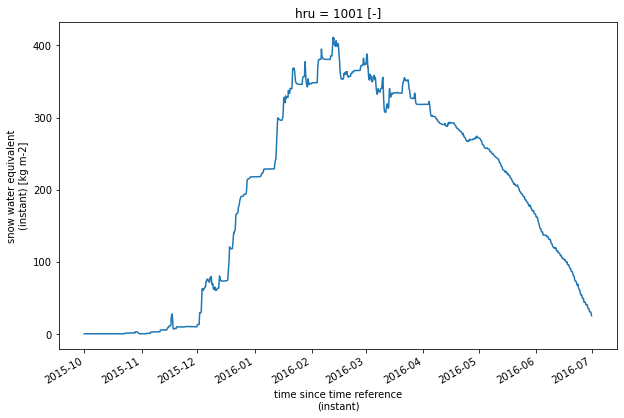

In [13]:
# plot output SWE
plt.figure(figsize=(10,6))
(s.output['scalarSWE']).plot(label='default')

In [3]:
# open various output from various runs to analyze
a = xr.open_dataset('./output/template_output_buck_RyanParams_wrf2016_timestep.nc')
b = xr.open_dataset('./output/template_output_273-15K_wrf2016_timestep.nc')
c = xr.open_dataset('./output/template_output_274-15K_wrf2016_timestep.nc')
d = xr.open_dataset('./output/template_output_274-15K_wrf2016_timestep.nc')
e = xr.open_dataset('./output/template_output_era_eLW_2016_timestep.nc')
f = xr.open_dataset('./output/template_output_eLW_wrf2016_timestep.nc')

# open snotel observations and convert units
snotel = pd.read_csv('./processing/buck_snotel_2016.txt')
snotel['time']= pd.to_datetime(snotel['time'])
snotel['airtemp'] = (snotel['airtemp']-32)*(5/9)
snotel['swe'] = snotel.swe.fillna(0)

In [ ]:
# compute MSE and RMSE for SWE for different runs compared to SNOTEL obs using sklearn
MSEa = mean_squared_error((snotel.swe[:5857]*25.4), a.scalarSWE)
RMSEa = np.round(math.sqrt(MSEa))

MSEb = mean_squared_error((snotel.swe[:5857]*25.4), b.scalarSWE)
RMSEb = np.round(math.sqrt(MSEb))

MSEc = mean_squared_error((snotel.swe[:5857]*25.4), c.scalarSWE)
RMSEc = np.round(math.sqrt(MSEc))

MSEd = mean_squared_error((snotel.swe[:5857]*25.4), d.scalarSWE)
RMSEd = np.round(math.sqrt(MSEd))

MSEe = mean_squared_error((snotel.swe[:5873]*25.4), e.scalarSWE[:5873])
RMSEe = np.round(math.sqrt(MSEe))

MSEf = mean_squared_error((snotel.swe[:5873]*25.4), f.scalarSWE[:5873])
RMSEf = np.round(math.sqrt(MSEf))

In [6]:
e['swe_diff'] = e.scalarSWE.diff(dim='time').dropna(dim='time')
# e.to_dataframe()

In [7]:
np.array(e['swe_diff']).flatten()

array([        nan,  0.        ,  0.        , ..., -0.35545269,
       -0.24135839, -0.19367295])

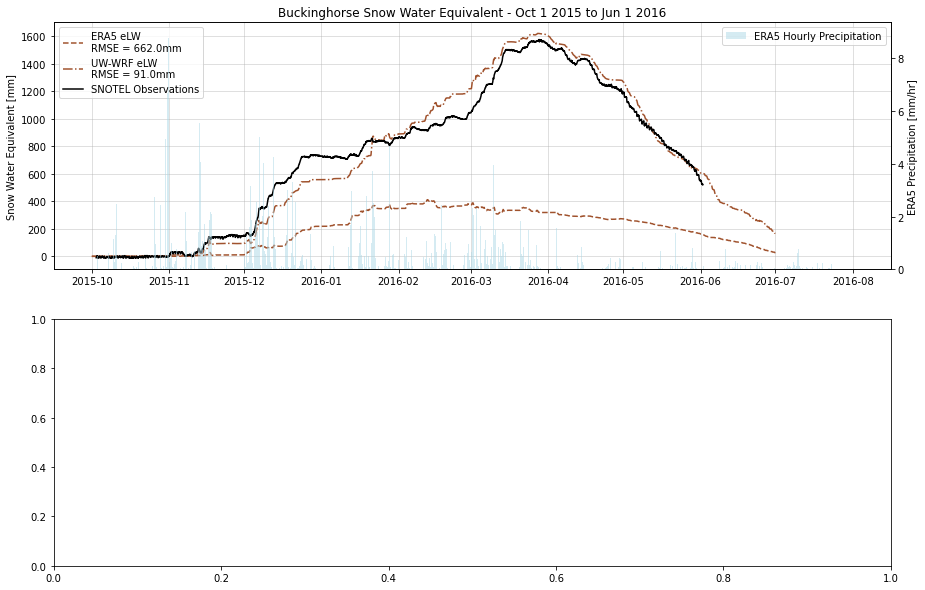

In [25]:
# plot output SWE and runoff for model runs and SNOTEL obs

fig, ax = plt.subplots(2, 1, figsize=(15,10))
# ax[0].plot(a.time, a.scalarSWE, label=f'Currier et al. Params\nRain/Snow=-1C\nRMSE = {RMSEa}mm', 
           # ls='-.')
# ax[0].plot(b.time, b.scalarSWE, label=f'Rain/Snow=0C\nRMSE = {RMSEb}mm', ls='--')
# ax[0].plot(c.time, c.scalarSWE, label=f'Rain/Snow=1C\nRMSE = {RMSEc}mm', ls='--')
# ax[0].plot(d.time, d.scalarSWE, label=f'Rain/Snow=2C\nRMSE = {RMSEd}mm', ls='--')
ax[0].plot(e.time, e.scalarSWE, label=f'ERA5 eLW\nRMSE = {RMSEe}mm', ls='--', c='sienna')
ax[0].plot(f.time, f.scalarSWE, label=f'UW-WRF eLW\nRMSE = {RMSEf}mm', ls='-.', c='sienna')
ax[0].plot(snotel.time, (snotel.swe*25.4), label='SNOTEL Observations', color='k')
ax[0].set_ylabel('Snow Water Equivalent [mm]')
ax[0].grid(alpha=0.5)
ax[0].legend(loc='upper left')
ax[0].set_title('Buckinghorse Snow Water Equivalent - Oct 1 2015 to Jun 1 2016')

# Create a second y-axis (ax2) for the bar chart
ax2 = ax[0].twinx()

# Add bar chart for ERA5 on the secondary y-axis (ax2)
ax2.bar(era_df.index, era_df.pptrate*3600, color='lightblue', alpha=0.5, width=pd.to_timedelta(1, 'H'), 
        label='ERA5 Hourly Precipitation')

# Set labels for the secondary y-axis
ax2.set_ylabel('ERA5 Precipitation [mm/hr]')
ax2.legend(loc='upper right')


'''# ax[1].plot(a.time, a.scalarTotalRunoff.cumsum()*3600*1000, label='Currier et al. Params\nRain/Snow=-1C', ls='-.')
# ax[1].plot(b.time, b.scalarTotalRunoff.cumsum()*3600*1000, label='Rain/Snow=0C', ls='--')
# ax[1].plot(c.time, c.scalarTotalRunoff.cumsum()*3600*1000, label='Rain/Snow=1C', ls='--')
# ax[1].plot(d.time, d.scalarTotalRunoff.cumsum()*3600*1000, label='Rain/Snow=2C', ls='--')
ax[1].plot(e.time, e.scalarTotalRunoff.cumsum()*3600*1000, label='ERA5 eLW', ls='--', c='sienna')
ax[1].plot(f.time, f.scalarTotalRunoff.cumsum()*3600*1000, label='UW-WRF eLW', ls='-.', c='sienna')
ax[1].set_ylabel('Runoff [mm]')
ax[1].grid(alpha=0.5)
ax[1].legend()
ax[1].set_title('Buckinghorse Cumulative Runoff - Oct 1 2015 to Jun 1 2016')'''

plt.savefig('./plots/swe_era5_wrf_2016.jpg', dpi=200)

In [11]:
# open WRF and ERA5 forcings
uw_wrf = xr.open_dataset('./forcings/buck_wrf_2016.nc')
era5 = xr.open_dataset('./forcings/buck_era5_2016.nc')
era_df = era5.to_dataframe()
era_df = era_df.reset_index()
era_df = era_df.set_index('time')

snotel['airtemp'] = (snotel['airtemp']-32)*(5/9)*1.03-0.9
temp = uw_wrf.airtemp.values-273.15

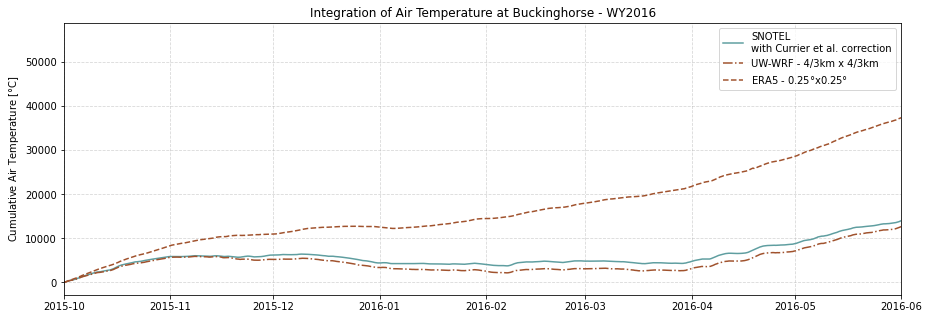

In [39]:
# plot integrated air temperature for Buckinghorse for both forcings and obs
plt.figure(figsize=(15,5))
plt.plot(snotel.time, snotel.airtemp.cumsum(), label='SNOTEL\nwith Currier et al. correction', 
         color='cadetblue')
plt.plot(uw_wrf.time, temp.cumsum(), label='UW-WRF - 4/3km x 4/3km', color='sienna', ls='-.')
plt.plot(era5.time, (era5.airtemp.values-273.15).cumsum(), l
         abel='ERA5 - 0.25$\degree$x0.25$\degree$', color='sienna', ls='--')
plt.ylabel('Cumulative Air Temperature [$\degree$C]')
plt.title('Integration of Air Temperature at Buckinghorse - WY2016')
plt.grid(alpha=0.5, ls='--')
plt.legend()
plt.savefig('./plots/buck_accTemp.jpeg', bbox_inches='tight', dpi=200)
plt.xlim([datetime.date(2015, 10, 1), datetime.date(2016, 6, 1)]);

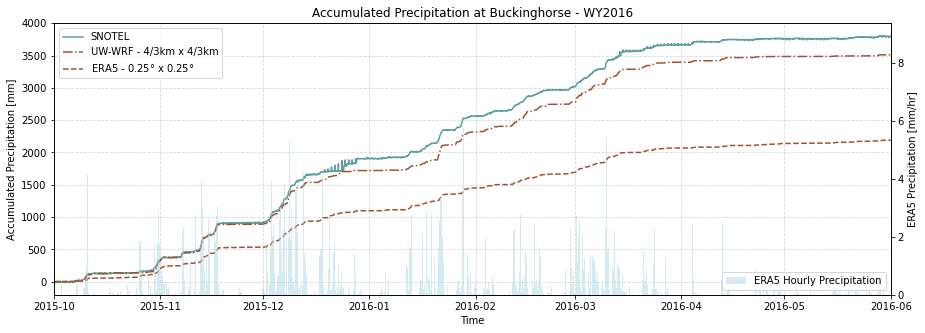

In [22]:
# plot accumulated precip and era5 hyetograph for Buckinghorse from forcings and obs
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot line charts on the primary y-axis (ax1)
ax1.plot(snotel.time, snotel.accPrecip * 25.4, label='SNOTEL', color='cadetblue')
ax1.plot(uw_wrf.time, uw_wrf.pptrate.values.cumsum() * 3600, 
         label='UW-WRF - 4/3km x 4/3km', color='sienna', ls='-.')
ax1.plot(era5.time, era5.pptrate.values.cumsum() * 3600, 
         label='ERA5 - 0.25$\degree$ x 0.25$\degree$', color='sienna', ls='--')

# Set labels and title
ax1.set_xlabel('Time')
ax1.set_ylabel('Accumulated Precipitation [mm]')
ax1.set_title('Accumulated Precipitation at Buckinghorse - WY2016')

# Create a second y-axis (ax2) for the bar chart
ax2 = ax1.twinx()

# Add bar chart for ERA5 on the secondary y-axis (ax2)
ax2.bar(era_df.index, era_df.pptrate*3600, color='lightblue', alpha=0.5, width=pd.to_timedelta(1, 'H'), 
        label='ERA5 Hourly Precipitation')

# Set labels for the secondary y-axis
ax2.set_ylabel('ERA5 Precipitation [mm/hr]')

# Show grid lines
ax1.grid(alpha=0.5, ls='--')

# Display legends
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

# Set x-axis limits
plt.xlim([datetime.date(2015, 10, 1), datetime.date(2016, 6, 1)])

plt.savefig('./plots/buck_accPrecip.jpeg', bbox_inches='tight', dpi=200)

# Display the plot
plt.show()

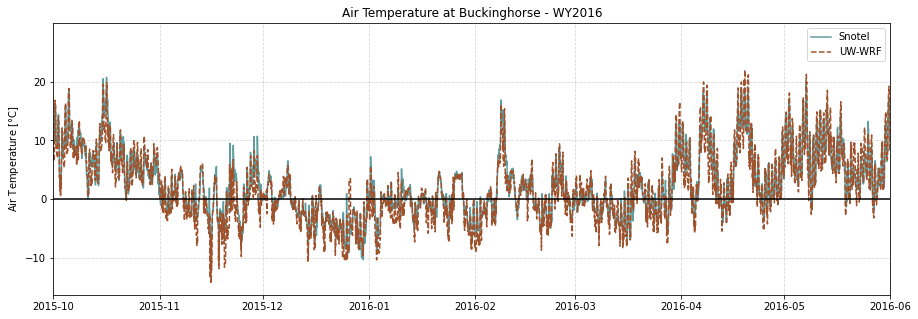

In [45]:
# plot air temp forcing from WRF and obs
plt.figure(figsize=(15,5))
plt.plot(snotel.time, snotel.airtemp.cumsum().diff(), label='Snotel', color='cadetblue')
plt.plot(uw_wrf.time[1:], np.diff(temp.cumsum()), label='UW-WRF', color='sienna', ls='--')
plt.axhline(0, c='k')

plt.ylabel('Air Temperature [$\degree$C]')
plt.grid(alpha=0.5, ls='--')
plt.title('Air Temperature at Buckinghorse - WY2016')
plt.legend()
plt.savefig('./plots/buck_airTemp.png', bbox_inches='tight', dpi=200)
plt.xlim([datetime.date(2015, 10, 1), datetime.date(2016, 6, 1)]);

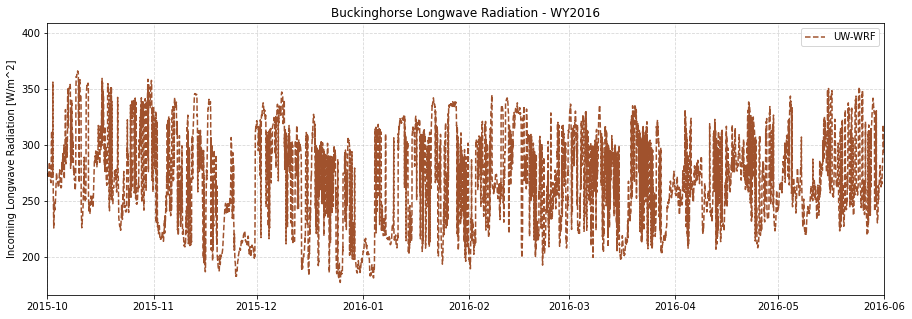

In [50]:
# plot LW radition forcings from WRF
plt.figure(figsize=(15,5))
plt.plot(uw_wrf.time, uw_wrf.LWRadAtm, label='UW-WRF', color='sienna', ls='--')
plt.ylabel('Incoming Longwave Radiation [W/m^2]')
plt.title('Buckinghorse Longwave Radiation - WY2016')
plt.grid(alpha=0.5, ls='--')
plt.legend()
plt.savefig('./plots/buck_LWRadAtm.png', bbox_inches='tight', dpi=200)
plt.xlim([datetime.date(2015, 10, 1), datetime.date(2016, 6, 1)]);